In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

### Generate Dataset

#### Load Data

In [2]:
f = open('../data/2dsamples_new3.npy','rb')
data = np.load(f, allow_pickle=True)

x = data[:,0:1]
y = data[:,1:]

#### Normalize data

2.7915405287041755 3.1367152280621764


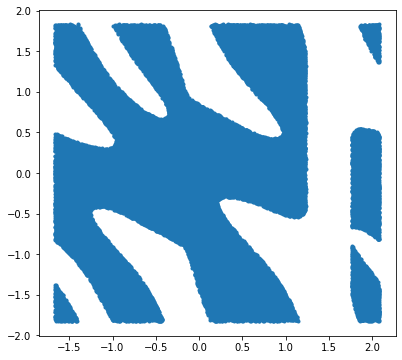

In [3]:
x_mean, x_std = np.mean(x), np.std(x)
y_mean, y_std = np.mean(y), np.std(y)
x = x - x_mean
y = y - y_mean
x /= x_std
y /= y_std
fig,ax = plt.subplots()
fig.set_size_inches(6.4, 6)
plt.plot(x[:,0], y[:,0], ".")

N = x.shape[0]
print(x_mean, y_mean)

In [4]:
samples = np.hstack([x, y])

In [5]:
def fk(x, l1 = 2., l2 = 3., unnormalize=True):
    if unnormalize:
        theta1, theta2 = x[...,0]*x_std + x_mean, x[...,1]*y_std + y_mean
    else:
        theta1, theta2 = x[...,0], x[...,1]        
    x1 = l1*tf.cos(theta1) + l2*tf.cos(theta1+ theta2)
    y1 = l1*tf.sin(theta1) + l2*tf.sin(theta1+ theta2)
    ee = tf.stack([x1,y1],axis=1)
    ee = tf.cast(ee, tf.float32)
    return ee

In [6]:
N = 50000
def sample_data_aug(batch):
    M = len(data_aug)
    ind = np.random.randint(low=0, high=M, size=(batch,))
    return data_aug[ind]

def sample_target(batch):
    M = len(data_target)
    ind = np.random.randint(low=0, high=M, size=(batch,))
    return data_target[ind]

def augment_q(q):
    ee = fk(q)
    q_aug = tf.concat([q, ee], axis=1)
    return q_aug

def sample_batch(batch_size = 32):
    idx = np.random.randint(low = 0, high = 50000, size = batch_size)
    return samples[idx]

In [7]:
samples = np.hstack([x, y])
data_aug = augment_q(samples).numpy()
data_target = fk(samples).numpy()

#### Learn Using VAE

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

In [106]:
input_dim = 2
latent_dim = 2
target_dim = 2
prior = tfd.MultivariateNormalDiag(tf.zeros(latent_dim))

In [107]:
encoder = Sequential([
    Dense(16, activation='relu', input_shape=(input_dim+target_dim,)),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
#     Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
#     tfpl.MultivariateNormalTriL(latent_dim)
    Dense(2*latent_dim)
    ,
    tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(
        loc=t[...,:latent_dim], scale_diag=tf.math.exp(t[...,latent_dim:])
    ))
    ,
    
    tfpl.KLDivergenceAddLoss(prior, weight=1., 
#                             test_points_fn=lambda q: q.sample(50),
#                             test_points_reduce_axis=0,
                            use_exact_kl=True)
])

In [108]:
decoder = Sequential([
    Dense(128, activation='relu', input_shape=(latent_dim+target_dim,)),
    Dense(64, activation='relu'),
    Dense(16, activation='relu'),
#     Dense(input_dim)
    Dense(2*input_dim),
    tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(
        loc=t[...,:input_dim], scale_diag=tf.math.exp(t[...,input_dim:])
    ))
#     Dense(tfpl.MultivariateNormalTriL.params_size(input_dim)),
#     tfpl.MultivariateNormalTriL(input_dim)
])

In [109]:
vae = Model(inputs=encoder.input, outputs=decoder(tf.concat([encoder.output, encoder.input[...,-target_dim:]],axis=-1)))

#### Train VAE

In [110]:
def loss_function(y_true, y_pred):
    w1 = 1.
    w2 = 1.
    
    ee_pred = fk(y_pred)
    ee_true = fk(y_true)
    loss_ee_mse = tf.reduce_sum(tf.keras.losses.mse(ee_true, ee_pred))
    loss_mse = -tf.reduce_sum(y_pred.log_prob(y_true))
    loss = w1*loss_mse + w2*loss_ee_mse
    return loss

In [111]:
vae.compile(loss=loss_function, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

In [112]:
samples_aug = augment_q(samples)

In [113]:
history = vae.fit(samples_aug, samples, epochs=40)

Epoch 1/40
1731/1731 [==============================] - 4s 1ms/step - loss: 356.2168
Epoch 2/40
1731/1731 [==============================] - 3s 1ms/step - loss: 276.2691
Epoch 3/40
1731/1731 [==============================] - 3s 1ms/step - loss: 175.5309
Epoch 4/40
1731/1731 [==============================] - 3s 2ms/step - loss: 131.0402
Epoch 5/40
1731/1731 [==============================] - 2s 1ms/step - loss: 113.0931
Epoch 6/40
1731/1731 [==============================] - 2s 1ms/step - loss: 98.0274
Epoch 7/40
1731/1731 [==============================] - 3s 1ms/step - loss: 82.4044
Epoch 8/40
1731/1731 [==============================] - 3s 2ms/step - loss: 56.9216
Epoch 9/40
1731/1731 [==============================] - 3s 2ms/step - loss: 46.3457
Epoch 10/40
1731/1731 [==============================] - 2s 1ms/step - loss: 38.8616
Epoch 11/40
1731/1731 [==============================] - 2s 1ms/step - loss: 33.3059
Epoch 12/40
1731/1731 [==============================] - 3s 2ms/step 

#### Try reconstructions

In [119]:
samples_reconstructed = vae(samples_aug)

(-2.0, 2.0)

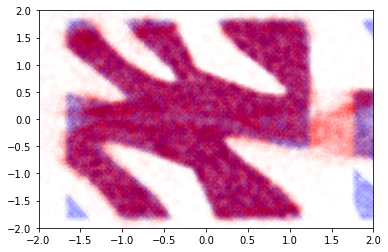

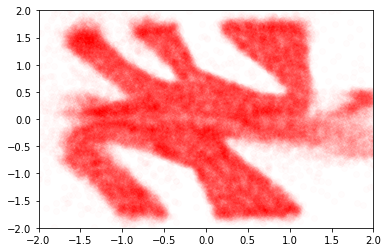

In [120]:
plt.figure()
plt.plot(samples_reconstructed[:,0], samples_reconstructed[:,1], 'or', alpha=0.01)
plt.plot(samples[:,0], samples[:,1], 'xb', alpha=0.01)
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.figure()
plt.plot(samples_reconstructed[:,0], samples_reconstructed[:,1], 'or', alpha=0.01)
plt.xlim([-2,2])
plt.ylim([-2,2])


#### See the encodings

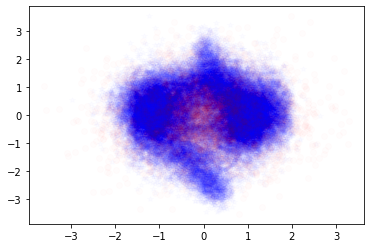

In [124]:
samples_encoded = encoder(samples_aug)
samples_prior = prior.sample(5000)

plt.plot(samples_encoded[:,0], samples_encoded[:,1], '*b', alpha=0.01)
# plt.show()
# plt.plot(samples_encoded[:,2], samples_encoded[:,3], '*b', alpha=0.01)
# plt.show()
# plt.plot(samples_encoded[:,4], samples_encoded[:,5], '*b', alpha=0.01)
# plt.show()

plt.plot(samples_prior[:,0], samples_prior[:,1], 'or', alpha=0.01)

#### See the reconstructions from the prior

In [125]:
ee_d = sample_target(len(samples_prior))

In [126]:
samples_prior_aug = tf.concat([samples_prior, ee_d], axis=-1)

In [127]:
samples_from_prior = decoder(samples_prior_aug).sample()

(-2.0, 2.0)

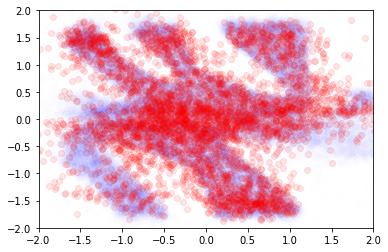

In [128]:
plt.plot(samples_reconstructed[:,0], samples_reconstructed[:,1], 'ob', alpha=0.005)
plt.plot(samples_from_prior[:,0], samples_from_prior[:,1], 'or', alpha=0.1)
plt.xlim([-2,2])
plt.ylim([-2,2])


(-2.0, 2.0)

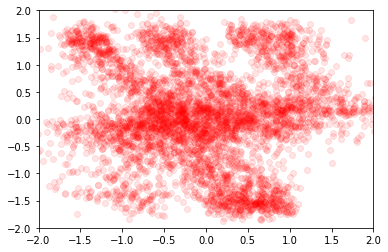

In [129]:
plt.plot(samples_from_prior[:,0], samples_from_prior[:,1], 'or', alpha=0.1)
plt.xlim([-2,2])
plt.ylim([-2,2])

In [130]:
ee_pred = fk(samples_from_prior).numpy()

In [131]:
err = np.linalg.norm(ee_pred-ee_d,axis=-1)

In [132]:
np.mean(err)

1.2956543

In [133]:
np.std(err)

1.5552547

#### Test

In [134]:
N = 1000
samples_prior = prior.sample(N)
x_aug = sample_data_aug(N)
y_true = x_aug[...,:-2]
ee_d = x_aug[...,-2:]
# ee_d = sample_target(len(samples_prior))
samples_prior_aug = tf.concat([samples_prior, ee_d], axis=-1)
samples_from_prior = decoder(samples_prior_aug).sample()
ee_pred = fk(samples_from_prior).numpy()

In [135]:
err = np.linalg.norm(ee_pred-ee_d,axis=-1)

In [136]:
samples_from_prior

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[ 0.12011001,  0.02347809],
       [ 0.9552249 ,  0.17194417],
       [ 0.60156673, -1.535197  ],
       ...,
       [-0.42778718,  0.34446764],
       [-0.07916441, -0.8224908 ],
       [ 1.2072448 ,  0.8550772 ]], dtype=float32)>

In [137]:
y_true

array([[ 1.7949378 , -0.06543592],
       [ 1.8890625 , -0.14860705],
       [ 0.57915705, -1.5501552 ],
       ...,
       [-0.7180525 ,  0.5973587 ],
       [ 1.2024378 ,  0.82985353],
       [ 1.1624777 ,  0.8493614 ]], dtype=float32)

(-2.0, 2.0)

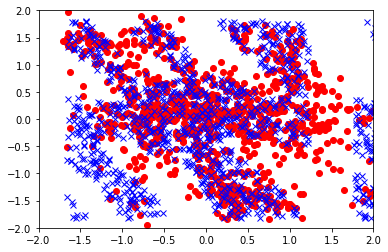

In [105]:
plt.plot(samples_from_prior[:,0], samples_from_prior[:,1], 'or')
plt.plot(y_true[:,0], y_true[:,1], 'xb')
plt.xlim([-2,2])
plt.ylim([-2,2])
